# Least Squares Based Supervised Classification

## Proof of correctness

$
\def\im{\implies}
\def\R{{\rm I\!R}}
$

\begin{align}
A^Hy = A^HA\hat{x}&\im A^Hy - A^HA\hat{x} = 0 \\
    &\im A^H(y - A\hat{x}) = 0 \\
    &\im a_i^H(y - A\hat{x}) = 0 \quad \forall i=1, ..., n \\
    &\im \langle y - A\hat{x}, a_i\rangle = 0 \quad \forall i = 1, ..., n \\
    &\im y - A\hat{x} \ \bot \ a_i \quad \forall i = 1, ..., n \\
    &\im y - A\hat{x} \ \bot \ span\{a_1, ..., a_n\} = R(A) \\
    &\im A\hat{x} \textit{ is the projection of y into R(A)} \\
    &\im \hat{x} \textit{ is the solution to } \min_{x} \|y-Ax\|_2^2 &&\textit{(Proven in class)} \\
    &\im \hat{x} \textit{ is the solution to } \min_x \|y-Ax\|_2 &&\textit{(Since } \sqrt{\cdot} \textit{ is a strictly decreasing function)}\\
\end{align}


(a) Will prove that $ A^Hy = A^HAx $ has always a solution by proving that $R(A^H) = R(A^HA)$, hence:

$$
    \forall y \ \exists x \ s.t. A^Hy = A^HAx
$$

Let $ \{b_1, ..., b_k\} $ be a basis of $R(A^HA)$

\begin{align}
R(A) \subseteq \R^m &\im R(A^HA) = \{A^Hz \mid z \in R(A)\} \ \subseteq \  \{A^Hy \mid y \in \R^m\} = R(A^H) \\
    &\im b_1, ..., b_k \in R(A^H) \\
    &\im b_1, ..., b_k \ \textit{linearly independent vectors in R(A^H)} &&(dim(R(A^H)) = dim(R(A^HA)) = k)\\
    &\im b_1, ..., b_k \ \textit{basis of} \ R(A^H) \\
    &\im R(A^HA) = span\{b_1, ..., b_k\} = R(A^H)
\end{align}

(b)

Case 1: $rank(A) = n \im rank(A^HA) = n \im A^Hy = A^HAx \ \text{has 1 unique solution}$

Case 2: $rank(A) < n \im rank(A^HA) < n \im A^Hy = A^HAx \ \text{has} \ \infty \ \text{solutions} \\
        (\text{because since } N(A^HA) \neq \{0\}, \ A^Hy = A^HAx \im \forall \alpha \in \R. \ A^Hy = A^HA(x + \alpha z) \text{ with } z \in N(A))$

## Least Squares Classifier

### (a) Implementation

In [1]:
import numpy as np

In [2]:
'''
LS regression model
    :param A: matrix in R^{mxn}
    :param y: vector in R^m
    :return: x that minimizes (L2-Norm(y - A*x))^2
'''
def LS_regression(A, y):
    square_A = A.conj().T @ A
    u, s, vh = np.linalg.svd(square_A)
    s = s[s >= 1.0e-3]
    r = s.size
    u = u[:, :r]
    vh = vh[:r]
    x = (vh.conj().T * np.reciprocal(s)) @ u.conj().T @ A.conj().T @ y
    return np.squeeze(x)

def sign(n):
    if n >= 0:
        return 1
    else:
        return -1
    
def ones_padding(X):
    m, n = X.shape
    ones = np.ones((m, 1))
    X_padded = np.hstack((X, ones))
    return X_padded

In [3]:
'''
Binary classifier
    :param X: matrix in R^{Nxm}, every row is the feature vector x^(i) in R^m
    :param y: vector in R^m, every entry is the label y^(i) for data point i, y^(i) in {-1, 1}
    :param pad: wether to pad X with a 1s column or not, default is True
    :return: f_hat, function that using (beta, alpha) that minimize (L2-Norm(y - (X|1) * (beta,alpha)))^2
             predicts a class in {-1, 1} for a given input x
'''
def binary_classifier(X, y, pad=True):
    X_one = ones_padding(X) if pad else np.copy(X)
    beta_alpha = LS_regression(X_one, y)
    
    def f_hat(x):
        if pad:
            return sign(beta_alpha[:-1].T @ x - beta_alpha[-1])
        else:
            return sign(beta_alpha.T @ x)
    
    return f_hat

In [4]:
'''
Multi-Class One-versus-All classifier
    :param X: matrix in R^{Nxm}, every row is the feature vector x^(i) in R^m
    :param y: vector in R^m, every entry is the label y^(i) for data point i, y^(i) in {0, ..., k-1}
    :param k: the number of classes
    :param pad: wether to pad X with a 1s column or not, default is True
    :return: f_hat, function that using (beta, alpha) that minimize (L2-Norm(y - (X|1) * (beta,alpha)))^2
             predicts a class in {0, ..., k-1} for a given input x
'''
def one_vs_all_classifier(X, y, k, pad=True):
    N, m = X.shape
    X_one = ones_padding(X) if pad else np.copy(X)
    Beta_Alpha = np.zeros((k, m+(1 if pad else 0)))
    
    for i in range(k):
        y_k = np.where(y == i, 1, -1)
        Beta_Alpha[i] = LS_regression(X_one, y_k)
    
    def f_hat(x):
        if pad:
            return np.argmax(Beta_Alpha[:, :-1] @ x + Beta_Alpha[:, -1])
        else:
            return np.argmax(Beta_Alpha @ x)
    
    return f_hat

In [5]:
'''
Multi-Class One-versus-One classifier
    :param X: matrix in R^{Nxm}, every row is the feature vector x^(i) in R^m
    :param y: vector in R^m, every entry is the label y^(i) for data point i, y^(i) in {0, ..., k-1}
    :param k: the number of classes
    :return: f_hat, function that using (beta, alpha) that minimize (L2-Norm(y - (X|1) * (beta,alpha)))^2
             predicts a class in {0, ..., k-1} for a given input x
'''
def one_vs_one_classifier(X, y, k, pad=True):
    Bin_classifiers = []
    
    for i in range(k):
        for j in range(i+1, k):
            filt = np.squeeze(np.logical_or(y == i, y == j))
            X_ij = X[filt]
            y_ij = y[filt]
            y_ij = np.where(y_ij == i, -1, 1)
            Bin_classifiers.append(binary_classifier(X_ij, y_ij, pad))
    
    def f_hat(x):
        votes = np.zeros(k)
        z = 0
        for i in range(k):
            for j in range(i+1, k):
                vote = Bin_classifiers[z](x)
                votes[i if vote == -1 else j] += 1
                z += 1
        return np.argmax(votes)
    
    return f_hat

### (b) Training and evaluation

In [6]:
import scipy.io as sio

mnist = sio.loadmat('mnist.mat')

In [7]:
testX = (mnist['testX'].astype('float')) / 255.0
testY = mnist['testY'].T.astype('float')
trainX = (mnist['trainX'].astype('float')) / 255.0
trainY = mnist['trainY'].T.astype('float')

In [8]:
print(testX.shape, testY.shape, trainX.shape, trainY.shape)

(10000, 784) (10000, 1) (60000, 784) (60000, 1)


In [9]:
K = 10

In [10]:
f_hat_onevall = one_vs_all_classifier(trainX, trainY, K)

In [11]:
f_hat_onevone = one_vs_one_classifier(trainX, trainY, K)

In [12]:
def evaluate(f_hat, data, labels, k):
    results = np.apply_along_axis(f_hat, 1, data)
    l = np.squeeze(labels)
    print('Error rate: ', np.sum(results != l)/data.shape[0])
    
    conf_matrix = np.zeros((k, k), dtype=int)
    for i in range(results.shape[0]):
        conf_matrix[int(l[i]), int(results[i])] += 1
        
    print('Confusion matrix: \n', conf_matrix)

In [13]:
print('One versus All classifier performance on training data: \n')
evaluate(f_hat_onevall, trainX, trainY, K)

One versus All classifier performance on training data: 

Error rate:  0.14228333333333334
Confusion matrix: 
 [[5682    7   18   14   24   43   64    4   61    6]
 [   2 6548   40   15   19   31   14   12   55    6]
 [  99  264 4792  149  108   11  234   91  192   18]
 [  42  167  176 5158   32  125   56  115  135  125]
 [  10   99   42    6 5212   50   39   23   59  302]
 [ 164   95   28  431  105 3992  192   36  235  143]
 [ 108   74   61    1   70   90 5476    0   35    3]
 [  55  189   37   47  170    9    2 5426   10  320]
 [  75  494   63  226  105  222   56   20 4410  180]
 [  68   60   20  117  371   12    4  492   38 4767]]


In [14]:
print('One versus One classifier performance on training data: \n')
evaluate(f_hat_onevone, trainX, trainY, K)

One versus One classifier performance on training data: 

Error rate:  0.2252
Confusion matrix: 
 [[5551    7    5    9    5   10   41    0  295    0]
 [   0 6659    4    8    1    0    2    0   64    4]
 [  19  406 4166  237   41    0  159    6  908   16]
 [  15  446   42 4359    5    1   32    4 1204   23]
 [  14  183   18    2 4259    0  113    1  125 1127]
 [  67  236   21  359   55  217  230    0 4150   86]
 [  15   55   12    1    4    1 5702    0  128    0]
 [  24  338   40   93   85    0   10 4618  318  739]
 [   5  230    1    9    2    0   36    0 5564    4]
 [  15   84   16   33   32    0    6   15  355 5393]]


In [15]:
print('One versus All classifier performance on test data: \n')
evaluate(f_hat_onevall, testX, testY, K)

One versus All classifier performance on test data: 

Error rate:  0.1398
Confusion matrix: 
 [[ 944    0    1    2    2    7   14    2    7    1]
 [   0 1107    2    2    3    1    5    1   14    0]
 [  18   54  813   26   15    0   42   22   37    5]
 [   4   18   23  879    5   17    9   21   22   12]
 [   0   22    6    1  881    5   10    2   11   44]
 [  23   18    3   72   24  659   23   14   39   17]
 [  18   10    9    0   22   17  875    0    7    0]
 [   5   40   16    6   26    0    1  884    0   50]
 [  14   46   11   30   27   40   15   12  759   20]
 [  15   11    2   17   80    1    1   77    4  801]]


In [16]:
print('One versus One classifier performance on test data: \n')
evaluate(f_hat_onevone, testX, testY, K)

One versus One classifier performance on test data: 

Error rate:  0.2315
Confusion matrix: 
 [[ 932    1    1    2    1    1   11    0   31    0]
 [   0 1123    1    3    0    0    1    0    7    0]
 [   8   87  680   41    8    0   25    1  181    1]
 [   3   63    6  715    0    0    4    0  214    5]
 [   2   34    6    1  703    0   26    0   24  186]
 [  10   32    2   62    6   40   31    0  695   14]
 [   8    9    5    0    3    0  912    0   21    0]
 [   3   63   10   15   15    0    2  744   64  112]
 [   4   24    1    4    4    0   10    0  926    1]
 [   6   14    0    6    4    0    1    0   68  910]]


### (c) Comments

The models generalized well on the test data: the error rate doesn't vary too much between training and test, hence the models didn't overfit to the training data

Looking at the test data, the digits that are:
* easier to classify are 1s and 6s, since they have the lowest percentage of "false negatives" (1s/6s that are classified as not 1s/6s)
* harder to classify are 5s by far, with the lowest percentage of true positives

## Randomized Feature Based LS Classifier

### (a) Implementation

In [17]:
L = 1000
Wb = np.random.normal(0, 1, size=(L, 784+1))

"""
Randomoized Feature Based LS CLassifier
    :param X: the training data
    :param y: the training labels
    :param L: dimension of the "feature space"
    :param g: real valued function to compute the feature mappings
    :param classifier_type: either "one_vs_one" or "one_vs_all"
    :param K: number of classes
    :return: f_hat the respective classifier trained on the feature mappings 
"""
def randomized_features_classifier(X, y, Wb, g, classifier_type, k):
    N, m = X.shape
    X_one = ones_padding(X)
    h_X = g(X_one @ Wb.T)
    if classifier_type == 'one_vs_one':
        return one_vs_one_classifier(h_X, y, K, pad=False)
    elif classifier_type == 'one_vs_all':
        return one_vs_all_classifier(h_X, y, K, pad=False)
    else:
        raise ValueError("classifier type not valid")


### (b) Training

In [18]:
def g1_identity(x):
    return x

def g2_sigmoid(x):
    return 1/(1 + np.exp(-x))

def g3_sinusoidal(x):
    return np.sin(x)

def g4_ReLU(x):
    return np.maximum(x, 0)

g = [g1_identity, g2_sigmoid, g3_sinusoidal, g4_ReLU]

#### One vs All Classifier

In [20]:
f_ovall = []
for i in range(len(g)):
    f_ovall.append(randomized_features_classifier(trainX, trainY, Wb, g[i], 'one_vs_all', K))

#### One vs One Classifier

In [21]:
f_ovone = []
for i in range(len(g)):
    f_ovone.append(randomized_features_classifier(trainX, trainY, Wb, g[i], 'one_vs_one', K))

### (c) Evaluation

In [22]:
def evaluate_with_feature(f_hat, g, Wb, data, labels, k):
    N, m = data.shape
    data_one = ones_padding(data)
    h_data = g(data_one @ Wb.T)
    evaluate(f_hat, h_data, labels, k)

In [23]:
print('One versus All randomized feature classifier performance: \n')
for i in range(len(f_ovall)):
    print(f'\nWith g_{i+1}(x):\n')
    print('\tOn training data:\n')
    evaluate_with_feature(f_ovall[i], g[i], Wb, trainX, trainY, K)
    print('\n\tOn test data:\n')
    evaluate_with_feature(f_ovall[i], g[i], Wb, testX, testY, K)
    print('\n---------------------------------')

One versus All randomized feature classifier performance: 


With g_1(x):

	On training data:

Error rate:  0.14226666666666668
Confusion matrix: 
 [[5682    7   18   14   24   43   64    4   61    6]
 [   2 6548   40   15   19   31   14   12   55    6]
 [  99  264 4792  149  108   11  234   91  192   18]
 [  42  167  176 5158   32  125   56  115  135  125]
 [  10   99   42    6 5212   50   39   23   59  302]
 [ 164   95   28  432  105 3991  192   36  235  143]
 [ 108   74   61    1   70   90 5476    0   35    3]
 [  55  189   37   47  170    9    2 5426   10  320]
 [  75  493   63  226  105  221   56   20 4412  180]
 [  68   60   20  117  371   12    4  492   38 4767]]

	On test data:

Error rate:  0.1397
Confusion matrix: 
 [[ 944    0    1    2    2    7   14    2    7    1]
 [   0 1107    2    2    3    1    5    1   14    0]
 [  18   54  813   26   15    0   42   22   37    5]
 [   4   17   23  880    5   17    9   21   22   12]
 [   0   22    6    1  881    5   10    2   11   44]

In [24]:
print('One versus One randomized feature classifier performance: \n')
for i in range(len(f_ovall)):
    print(f'\nWith g_{i+1}(x):\n')
    print('\tOn training data:\n')
    evaluate_with_feature(f_ovone[i], g[i], Wb, trainX, trainY, K)
    print('\n\tOn test data:\n')
    evaluate_with_feature(f_ovone[i], g[i], Wb, testX, testY, K)
    print('\n---------------------------------')

One versus One randomized feature classifier performance: 


With g_1(x):

	On training data:

Error rate:  0.06213333333333333
Confusion matrix: 
 [[5805    3   15    8   11   20   22    6   32    1]
 [   2 6623   36   17    7   16    2   11   21    7]
 [  51   69 5521   49   57   20   41   44   93   13]
 [  26   42  120 5580    8  160   19   48   89   39]
 [  14   18   20    5 5586   11   14   16    8  150]
 [  43   46   39  138   22 4970   93   10   47   13]
 [  27   16   35    2   30   84 5693    0   30    1]
 [   8   76   54    7   68   10    0 5883    5  154]
 [  35  192   43  108   48  143   38   25 5154   65]
 [  21   14   18   83  155   31    3  137   30 5457]]

	On test data:

Error rate:  0.0696
Confusion matrix: 
 [[ 962    0    1    1    0    6    7    3    0    0]
 [   0 1120    3    3    1    1    4    1    2    0]
 [   9   17  938   12   10    5   10    9   22    0]
 [   8    1   19  927    2   19    1    7   21    5]
 [   3    2    8    2  929    1    7    4    3   23]

Pretty much every (model, nonlinear-function) combination seems to keep on generalizing well on test data. Out of the 2, One versus one classifiers tend to do a little bit poorly on test data compared to training data, but just a minimal difference

### (d) Feature number variation

I will continue this analysis only considering the best and fastest to compute non-linear function: ReLU

In [25]:
Ls = [800, 900, 1000, 1100, 1200]
Ws = []
for l in Ls:
    Ws.append(np.random.normal(0, 1, size=(l, 784+1)))
f_ovall_new = []
f_ovone_new = []
for w in Ws:
    f_ovall_new.append(randomized_features_classifier(trainX, trainY, w, g[3], 'one_vs_all', K))
    f_ovone_new.append(randomized_features_classifier(trainX, trainY, w, g[3], 'one_vs_one', K))

In [26]:
N, m = testX.shape
testX_one = ones_padding(testX)

h_testX = []
for w in Ws:
    h_testX.append(g[3](testX_one @ w.T))

def error_rate(f_hat, data, labels):
    results = np.apply_along_axis(f_hat, 1, data)
    new_labels = np.squeeze(labels)
    return np.sum(results != new_labels)/data.shape[0]

errors = np.zeros((len(Ws), 2))
for i in range(len(Ws)):
    for j in range(2):
        errors[i][0] = error_rate(f_ovall_new[i], h_testX[i], testY)
        errors[i][1] = error_rate(f_ovone_new[i], h_testX[i], testY)

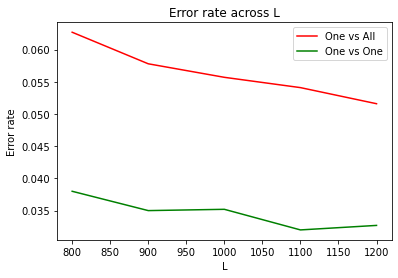

In [27]:
import matplotlib.pyplot as plt

plt.plot(Ls, errors[:, 0], 'r')
plt.plot(Ls, errors[:, 1], 'g')
plt.legend(['One vs All', 'One vs One'])

plt.title('Error rate across L')
plt.xlabel('L')
plt.ylabel('Error rate')
plt.show()

From what it can be easily seen from the plot, adding more features tends to decrease the error rate of the classifier